Basic AlexNet Example
--------

This notebook shows how to use MXNet construct AlexNet. AlexNet is made by Alex Krizhevsky in 2012.

We  will show how to train AlexNet in Python with single/multi GPU. All you need is to write a piece of Python code to describe network, then MXNet will help you finish all work without any of your effort. 

Notice: This notebook is a basic demo to show MXNet flavor. To train a full state-of-art network, please refer our ```Inception``` example.

Generally, we need 

- Declare symbol network
- Declare data iterator
- Bind symbol network to device to model
- Fit the model

In [1]:
import mxnet as mx

Now we have successully load MXNet. we will start declare a symbolic network. 

In [2]:
input_data = mx.symbol.Variable(name="data")

We use a special symbol ```Variable``` to represent input data.

In [3]:
# stage 1
conv1 = mx.symbol.Convolution(data=input_data, kernel=(11, 11), stride=(4, 4), num_filter=96)
relu1 = mx.symbol.Activation(data=conv1, act_type="relu")
pool1 = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(3, 3), stride=(2,2))
lrn1 = mx.symbol.LRN(data=pool1, alpha=0.0001, beta=0.75, knorm=1, nsize=5)
# stage 2
conv2 = mx.symbol.Convolution(data=lrn1, kernel=(5, 5), pad=(2, 2), num_filter=256)
relu2 = mx.symbol.Activation(data=conv2, act_type="relu")
pool2 = mx.symbol.Pooling(data=relu2, kernel=(3, 3), stride=(2, 2))
lrn2 = mx.symbol.LRN(data=pool2, alpha=0.0001, beta=0.75, knorm=1, nsize=5)
# stage 3
conv3 = mx.symbol.Convolution(data=lrn2, kernel=(3, 3), pad=(1, 1), num_filter=384)
relu3 = mx.symbol.Activation(data=conv3, act_type="relu")
conv4 = mx.symbol.Convolution(data=relu3, kernel=(3, 3), pad=(1, 1), num_filter=384)
relu4 = mx.symbol.Activation(data=conv4, act_type="relu")
conv5 = mx.symbol.Convolution(data=relu4, kernel=(3, 3), pad=(1, 1), num_filter=256)
relu5 = mx.symbol.Activation(data=conv5, act_type="relu")
pool3 = mx.symbol.Pooling(data=relu5, kernel=(3, 3), stride=(2, 2))
# stage 4
flatten = mx.symbol.Flatten(data=pool3)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=4096)
relu6 = mx.symbol.Activation(data=fc1, act_type="relu")
dropout1 = mx.symbol.Dropout(data=relu6, p=0.5)
# stage 5
fc2 = mx.symbol.FullyConnected(data=dropout1, num_hidden=4096)
relu7 = mx.symbol.Activation(data=fc2, act_type="relu")
dropout2 = mx.symbol.Dropout(data=relu7, p=0.5)
# stage 6
fc3 = mx.symbol.FullyConnected(data=dropout2, num_hidden=1000)
softmax = mx.symbol.Softmax(data=fc3)

Now we have a AlexNet in symbolic level. The ```softmax``` symbol contains all network structures. By indicate ```data``` for each symbol, the last symbol composite all info we need. We can visualize our network structure. (require ```graphviz``` package)

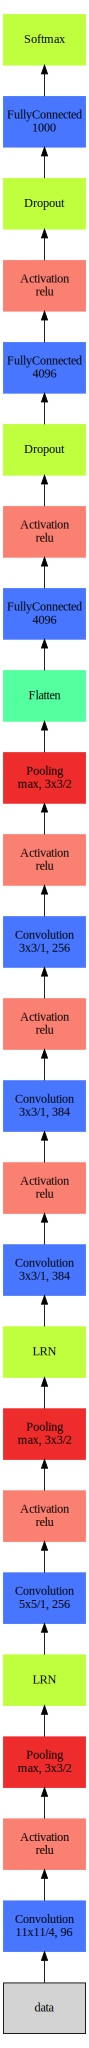

In [4]:
mx.viz.plot_network(softmax)

The next step is declare data iterator. We provide high perfomance RecordIO image iterator for ImageNet task. Please pack the images into record file before use. For how to pack image and more details about image data iterator and build-in io iterator, please read [io doc](https://github.com/dmlc/mxnet/blob/master/doc/python/io.md)

In [5]:
# We set batch size for to 256
batch_size = 256
# We need to set correct path to image record file
# For ```mean_image```. if it doesn't exist, the iterator will generate one
# On HDD, single thread is able to process 800 images / sec
# the input shape is in format (channel, height, width)
# rand_crop option make source image randomly cropped to input_shape (3, 224, 224)
# rand_mirror option make source image randomly mirrored
# We use 2 threads to processing our data
train_dataiter = mx.io.ImageRecordIter(
    shuffle=True,
    path_imgrec="./Data/ImageNet/train.rec",
    mean_img="./Data/ImageNet/mean_224.bin",
    rand_crop=True,
    rand_mirror=True,
    data_shape=(3, 224, 224),
    batch_size=batch_size,
    prefetch_buffer=4,
    preprocess_threads=2)
# similarly, we can declare our validation iterator
val_dataiter = mx.io.ImageRecordIter(
    path_imgrec="./Data/ImageNet/val.rec",
    mean_img="./Data/ImageNet/mean_224.bin",
    rand_crop=False,
    rand_mirror=False,
    data_shape=(3, 224, 224),
    batch_size=batch_size,
    prefetch_buffer=4,
    preprocess_threads=2)

Next step, we will initialize our model from symbol. To run on a single GPU, we need to declare:

In [9]:
# For demo purpose, we just run 1 epoch
num_round = 1
# set context to GPU, if you want to use cpu, set it to mx.cpu()
ctx = mx.gpu() 
# note: for input shape in model, we must contain batch size
data_shape = (batch_size, 3, 224, 224)

model = mx.model.FeedForward(symbol=softmax, ctx=ctx, input_shape=data_shape, num_round=num_round,
                             learning_rate=0.01, momentum=0.9, wd=0.0001)

To run on multiply GPU, we need to declare

In [ ]:
# For demo purpose, we just run 1 epoch
num_round = 1
# Assume we have 4 GPU, we can make a context list contains 4 device
num_devs = 4
ctx = [mx.gpu(i) for i in range(num_devs)]
# note: for input shape in model, we must contain batch size
data_shape = (batch_size, 3, 224, 224)

model = mx.model.FeedForward(symbol=softmax, ctx=ctx, input_shape=data_shape, num_round=num_round,
                             learning_rate=0.01, momentum=0.9, wd=0.0001)

In [10]:
# Now we can fit the model with data iterators
# When we use data iterator, we don't need to set y because label comes from data iterator directly
# In this case, eval_data is also a data iterator
# We will use accuracy to measure our model's performace
model.fit(X=train_dataiter, eval_data=val_dataiter, eval_metric='acc')
# You need to wait for a while to get the result

MXNetError: [12:00:28] src/ndarray/ndarray.cc:157: Check failed: from.shape() == to->shape() operands shape mismatch

That's all!